In [1]:
import numpy as np 
from collections import defaultdict
from tqdm import tqdm
import re, os, csv
from sklearn.model_selection import train_test_split
import json
import matplotlib.pyplot as plt

In [2]:
MOVIELEN_PATH = './data/movielens'
out_path = os.path.join(MOVIELEN_PATH, 'utils')

neg_num = 20 
STARTDATE = 19950109000000  
ENDATE = 20150331000000 

TRAINDATE = 20100101000000
TESTDATE = 20140601000000
RATING_THRESHOLD = 4 

In [7]:
def process_news(movielen_path, add_label=False):
    news_title = {} # nid: title 
    news_cat = {}
    cat_count = {}
    fname = os.path.join(movielen_path, 'movie.csv')
    with open(fname, 'r') as fo:
        csvr = csv.reader(fo) 
        for _,row in enumerate(csvr):
            if _ == 0:
                continue
            nid = row[0]
            title = row[1] #[s.lower() for s in row[1].split(' ')[:-1]]
            labels = row[2] #[s.lower() for s in row[2].split('|')]
            if add_label:
                title = title + labels
            news_title[nid] = title #[:max_title_len] #word_tokenize(title)[:max_title_len]
            
            cat = labels.split('|')[0]
            news_cat[nid] = cat
            if cat in cat_count:
                cat_count[cat] += 1
            else:
                cat_count[cat] = 1

    cat_count = {k: v for k, v in sorted(cat_count.items(), key=lambda item: item[1])}
    print(cat_count)
    plt.hist(list(cat_count.values()), bins=50)


    nid2index = {k: v for k, v in zip(news_title.keys(), range(1, len(news_title) + 1))}
    
    print(len(news_cat))
    unique_cat = list(set(list(news_cat.values())))
    print('unique categories: ', len(unique_cat))

    # json_path = os.path.join(out_path, 'subcategory_byorder.json')
    # with open(json_path, 'w') as f:
    #     json.dump(unique_cat, f)
            
    return news_title, nid2index, news_cat

def convert_date_format(longdate):
    """longdate = yyyymmddhhmmss 
    Return: 11/15/2019 8:55:22 AM
    """
    yyyy = longdate[:4] 
    mm = longdate[4:6] 
    dd = longdate[6:8] 
    hh = longdate[8:10]
    mm = longdate[10:12]
    ss = longdate[12:14] 

    if int(hh) > 12:
        hh = str(hh % 12)
        postfix = 'PM'
    else:
        postfix = 'AM'

    return '{}/{}/{} {}:{}:{} {}'.format(mm,dd,yyyy, hh,mm,ss,postfix)

{'IMAX': 1, 'War': 35, 'Film-Noir': 38, 'Musical': 94, 'Fantasy': 137, 'Romance': 145, 'Mystery': 146, 'Sci-Fi': 168, 'Western': 215, '(no genres listed)': 246, 'Thriller': 279, 'Children': 414, 'Animation': 571, 'Adventure': 1357, 'Horror': 1380, 'Crime': 1617, 'Documentary': 2247, 'Action': 3520, 'Comedy': 6793, 'Drama': 7875}
27278
unique categories:  20


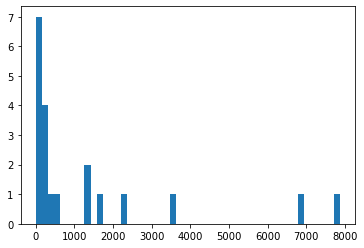

In [8]:
news_title, nid2index, news_cat = process_news(MOVIELEN_PATH)

In [4]:
class UserInfo:
    def __init__(self):
        """ Split the entire time horizon into 3 splits: first split for history, second for train and third for test
        """
        self.startdate = STARTDATE  
        self.enddate = ENDATE 

        self.traindate = TRAINDATE
        self.testdate = TESTDATE
        self.threshold = RATING_THRESHOLD

        self.history_news = []
        self.history_time = []

        self.train_pos_news = []
        self.train_pos_time = []

        self.train_neg_news = []
        self.train_neg_time = []

        self.test_pos_news = []
        self.test_pos_time = []

        self.test_neg_news = []
        self.test_neg_time = []

        self.mindate = self.enddate 
        self.maxdate = self.startdate


    def update(self, nindex, time, rating):
        """ Update pos news and time 
                   neg news and time 
        """

        self.mindate = min(self.mindate, time) 
        self.maxdate = max(self.maxdate, time)

        if time < self.traindate: 
            if rating >= self.threshold:
                self.history_news.append(nindex)
                self.history_time.append(time)
        elif time < self.testdate: 
            if rating >= self.threshold:
                self.train_pos_news.append(nindex)
                self.train_pos_time.append(time)
            else:
                self.train_neg_news.append(nindex)
                self.train_neg_time.append(time)

        else: 
            assert time >= self.testdate 
            if rating >= self.threshold:
                self.test_pos_news.append(nindex)
                self.test_pos_time.append(time)
            else:
                self.test_neg_news.append(nindex)
                self.test_neg_time.append(time)


    def sort_click(self):
        self.history_news = np.array(self.history_news, dtype="int32")
        self.history_time = np.array(self.history_time, dtype="int32")

        self.train_pos_news = np.array(self.train_pos_news, dtype="int32")
        self.train_pos_time = np.array(self.train_pos_time, dtype="int32")

        self.train_neg_news = np.array(self.train_neg_news, dtype="int32")
        self.train_neg_time = np.array(self.train_neg_time, dtype="int32")


        self.test_pos_news = np.array(self.test_pos_news, dtype="int32")
        self.test_pos_time = np.array(self.test_pos_time, dtype="int32")

        self.test_neg_news = np.array(self.test_neg_news, dtype="int32")
        self.test_neg_time = np.array(self.test_neg_time, dtype="int32")


        order = np.argsort(self.train_pos_time)
        self.train_pos_time = self.train_pos_time[order]
        self.train_pos_news = self.train_pos_news[order]

        order = np.argsort(self.train_neg_time)
        self.train_neg_time = self.train_neg_time[order]
        self.train_neg_news = self.train_neg_news[order]
        
        order = np.argsort(self.test_pos_time)
        self.test_pos_time = self.test_pos_time[order]
        self.test_pos_news = self.test_pos_news[order]


        order = np.argsort(self.test_neg_time)
        self.test_neg_time = self.test_neg_time[order]
        self.test_neg_news = self.test_neg_news[order]

        order = np.argsort(self.history_time)
        self.history_time = self.history_time[order]
        self.history_news = self.history_news[order]

In [5]:
def process_users(movielen_path):
    uid2index = {}
    user_info = defaultdict(UserInfo) # for each user 


    rating_fname = os.path.join(movielen_path, 'rating.csv')

    with open(rating_fname, 'r') as fo: 
        rating_reader = csv.reader(fo)

        table = []

        for _, row in tqdm(enumerate(rating_reader)): 
            if _ == 0:
                continue 

            uid = row[0]
            nid = row[1]
            tsp = row[3].split(' ')
            rating = float(row[2])

            time = int(''.join(tsp[0].split('-') + tsp[-1].split(':')))

            if uid not in uid2index:
                uid2index[uid] = len(uid2index)
                
            uindex = uid2index[uid] 
            user_info[uindex].update(nid2index[nid], time, rating)

    return uid2index, user_info

In [6]:
def construct_behaviors(uindex, hist_news, train_pos_news, train_neg_news, test_pos_news, test_neg_news, neg_num):
    p = np.ones(len(news_title) + 1, dtype="float32")
    p[hist_news] = 0
    p[train_pos_news] = 0
    p[test_pos_news] = 0
    p[0] = 0
    p /= p.sum()


    train_his_news = [str(i) for i in hist_news.tolist()]

    train_his_line = " ".join(train_his_news)

    for nindex in train_pos_news:
        if len(train_neg_news) > 0:
            neg_cand = np.random.choice(train_neg_news, size=neg_num).tolist()
        else: 
            neg_cand =  np.random.choice(len(news_title) + 1, size=neg_num, replace=False, p=p).tolist()

        cand_news = " ".join(
            [f"{str(nindex)}-1"] + [f"{str(nindex)}-0" for nindex in neg_cand]
        )

        train_behavior_line = f"null\t{uindex}\tnull\t{train_his_line}\t{cand_news}\n"
        train_lines.append(train_behavior_line)

    test_his_news = [str(i) for i in hist_news.tolist() + train_pos_news.tolist()]
    test_his_line = " ".join(test_his_news)

    for nindex in test_pos_news:
        if len(test_neg_news) > 0: 
            neg_cand = np.random.choice(test_neg_news, size=neg_num).tolist()
        else: 
            neg_cand =  np.random.choice(len(news_title) + 1, size=neg_num, replace=False, p=p).tolist()
    
        cand_news = " ".join(
            [f"{str(nindex)}-1"] + [f"{str(nindex)}-0" for nindex in neg_cand]
        )

        test_behavior_line = f"null\t{uindex}\tnull\t{test_his_line}\t{cand_news}\n"
        test_lines.append(test_behavior_line)

In [7]:
def write_news_files(news_title, nid2index, news_category, out_path):
    # Output with MIND format
    news_lines = []
    for nid in tqdm(news_title):
        nindex = nid2index[nid]
        title = news_title[nid]
        if nid in news_category:
            category = news_category[nid]
        else:
            category = ""
        news_line = "\t".join([str(nindex), "", category, title, "", "", "", ""]) + "\n"
        news_lines.append(news_line)

    for stage in ["train", "valid", "test"]:
        file_path = os.path.join(out_path, stage)
        os.makedirs(file_path, exist_ok=True)
        with open(os.path.join(file_path, "news.tsv"), "w", encoding="utf-8") as f:
            f.writelines(news_lines)

In [ ]:
write_news_files(news_title, nid2index, news_cat, out_path)
uid2index, user_info = process_users(MOVIELEN_PATH)

In [28]:
for uid in tqdm(user_info):
    user_info[uid].sort_click()

train_lines = []
test_lines = []
for uindex in tqdm(user_info):
    uinfo = user_info[uindex]
    hist_news = uinfo.history_news
    train_pos_news = uinfo.train_pos_news
    train_neg_news = uinfo.train_neg_news
    test_pos_news = uinfo.test_pos_news
    test_neg_news = uinfo.test_neg_news

    # Filter 
    if uinfo.maxdate < uinfo.testdate or uinfo.mindate > uinfo.traindate or len(uinfo.train_pos_news) == 0 or len(uinfo.test_pos_news) == 0: 
        # train_neg_news, test_neg_news can be empty 
        continue # skip 

    construct_behaviors(uindex, hist_news, train_pos_news, train_neg_news, test_pos_news, test_neg_news, neg_num)

100%|██████████| 128294/128294 [00:04<00:00, 31883.40it/s]


In [29]:
test_split_lines, valid_split_lines = train_test_split(
    test_lines, test_size=0.2, random_state=2021)

for stage, flines in zip(['train', 'valid', 'test'], [train_lines, valid_split_lines, test_lines]):
    with open(os.path.join(out_path, stage, "behaviors.tsv"), "w", encoding="utf-8") as f:
        f.writelines(flines)